In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

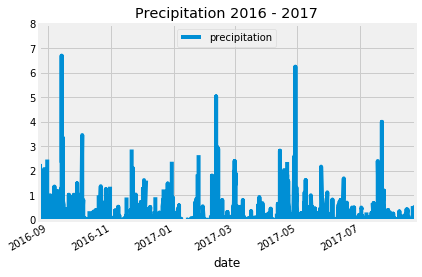

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.date).order_by(Measurement.date.desc())
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = latest_date[0]
latest_date

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(latest_date, "%Y-%m-%d")- dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipscores = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precipscores, columns = ["date", "precipitation"])
precip_df["date"] = pd.to_datetime(precip_df["date"], format = "%Y-%m-%d")
precip_df.set_index("date", inplace = True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by="date", ascending = True)
precip_df

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Precipitation 2016 - 2017")
plt.legend(loc="upper center")
plt.ylim(0,8)
plt.savefig("Images/Precipitation.png", bbox_inches="tight")
plt.show()

![precipitation](Images/precipitation.png)

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [22]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_active = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = stations_active[0][0]
most_active_station

temp_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
temp_stats

[(54.0, 85.0, 71.66378066378067)]

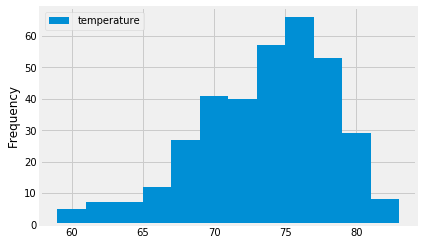

In [26]:
# Choose the station with the highest number of temperature observations.
station_most_tempstats = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
station_most_tempstats = station_most_tempstats [0]
station_most_tempstats

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempstats_12months = session.query(Measurement.tobs).filter(Measurement.date>=year_ago).filter(Measurement.station == station_most_tempstats).all()

temperature_observation = pd.DataFrame(tempstats_12months, columns=["temperature"])

temperature_observation.plot.hist(bins=12)
plt.savefig("Images/frequency.png", bbox_inches="tight")
plt.show()


![precipitation](Images/station-histogram.png)

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps= calc_temps('2012-02-28', '2012-03-05')

d1= dt.date(2012,2,28)
d2= dt.date(2012,3,5)

trip_days = d2-d1

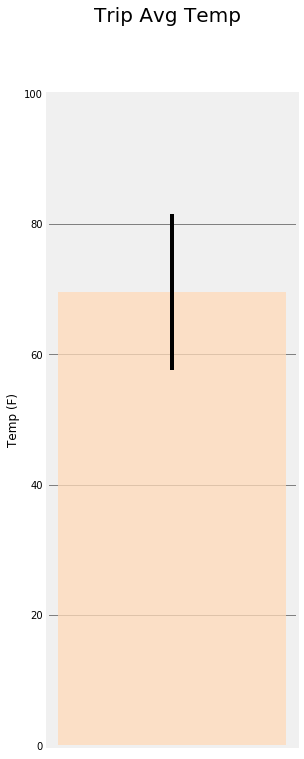

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps[0][1]

trip_dict = {'tmin':trip_temps[0][0],'tavg':trip_temps[0][1],'tmax':trip_temps[0][2]}
yerr=trip_dict['tmax'] - trip_dict['tmin']

plt.figure(figsize=(4,12))
plt.bar(1,trip_dict['tavg'],yerr=yerr,align='center',color='peachpuff', alpha= .75)
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.grid(color='gray', linestyle='-', linewidth=1,)
plt.suptitle("Trip Avg Temp", size = 20)
plt.show()

In [61]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel= [Station.station,Station.name,Station.elevation, Station.longitude, Station.elevation,
                  func.sum(Measurement.prcp)]
rainfall_info = session.query(*sel).filter(Measurement.station == Station.station)\
                .filter(Measurement.date >= '2017-04-14')\
                .filter(Measurement.date <= '2017-04-21').group_by(Station.station)\
                .order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall_info)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 152.4, -157.8025, 152.4, 8.09), ('USC00519281', 'WAIHEE 837.5, HI US', 32.9, -157.84888999999998, 32.9, 8.029999999999998), ('USC00513117', 'KANEOHE 838.1, HI US', 14.6, -157.8015, 14.6, 3.63), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, -157.71139, 19.5, 3.5199999999999996), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7.0, -157.8374, 7.0, 1.46), ('USC00519397', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 3.0, 0.5900000000000001), ('USC00517948', 'PEARL CITY, HI US', 11.9, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


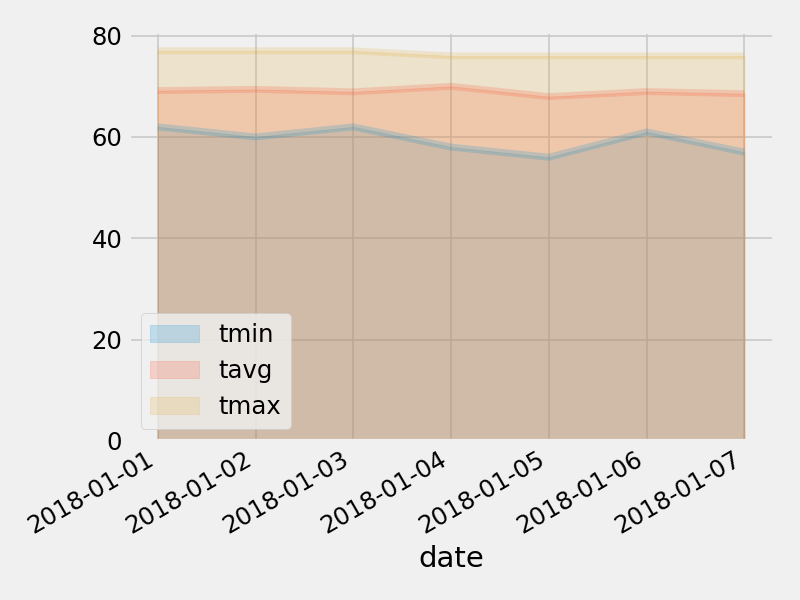

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
